In [ ]:
# The aim of this case study is to show an example of satellite observation product validation at local level, to ensure that user access the
# data quality at local level. In-situ data from Ameriflux site US-DS3, which provide in-situ latent heat flux data between 2021 and 2024. 
# All daily LE_CORR data are converted to daily ET, 
# The WaPOR ET collection ID on FERSPAS is "L1-UTM-AETI-D"
# All ET data of cover US-DS3 are downloaded the the ET value are extracted, a time series comparison and a scatter plot are generated.
# Results showed the the Earth Observation ET have underestimation in pre-season periods, the R2 is 0.55 and RMSE is 1.51 mm/day.
# Created by Pengyu Hao (pengyu.hao@fao.org), on 2026/01/22 

In [11]:
from pystac_client import Client
from datetime import datetime, timedelta
from urllib.parse import urlparse
import glob
import gcsfs
import rasterio
import numpy as np
import pandas as pd
from rasterio import transform
from rasterio.warp import transform as transform_coords
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
#the link to the stac in production
API_ROOT = "https://data.apps.fao.org/geospatial/search/stac"
#using client functions to see all collections available in the STAC
client = Client.open(API_ROOT)

In [6]:
#input filters for data selection
# === EDIT THESE ===
# You can put: []  or ""  or None  to search without a collection filter.
# Or provide one or many collection ids, e.g. ["L1-UTM-NPP-D"] or "L1-UTM-NPP-D"
COLLECTIONS = "L1-UTM-AETI-D"   # or [] or None
# Bounding box in WGS84 [minx, miny, maxx, maxy]; set to None to ignore
BBOX =[-122, 38, -121, 39]   # or None
# Time range; set to None to ignore (STAC interval string "start/end")
#print(starttime_str)
DATETIME = "2021-01-01/2024-12-31"  # or None
# Optional: LIKE pattern for item id (SQL wildcards: % = any string, _ = single char)
# Example: "%60W.2024-12-D3%"  |  set to None to skip LIKE filtering
ITEM_ID_LIKE = None
# Optional extra STAC 'query' filter
QUERY = {
    # "eo:cloud_cover": {"lt": 20}
}
# Optional cap on results
LIMIT = 100
print("STAC_API:", API_ROOT)
print("COLLECTIONS:", COLLECTIONS)
print("BBOX:", BBOX)
print("DATETIME:", DATETIME)
print("ITEM_ID_LIKE:", ITEM_ID_LIKE)

STAC_API: https://data.apps.fao.org/geospatial/search/stac
COLLECTIONS: L1-UTM-AETI-D
BBOX: [-122, 38, -121, 39]
DATETIME: 2021-01-01/2024-12-31
ITEM_ID_LIKE: None


In [7]:
#functions to select items from collection
def _normalize_collections(val):
    if val is None:
        return None
    if isinstance(val, str):
        val = val.strip()
        return [val] if val else None
    if isinstance(val, (list, tuple)):
        vals = [v for v in (x.strip() for x in val) if v]
        return vals or None
    return None

search_kwargs = dict(
    collections=_normalize_collections(COLLECTIONS),
    bbox=BBOX or None,
    datetime=DATETIME or None,
    query=QUERY or None,
    limit=LIMIT,
)

#get and show the list of the selected items of the recent 15 day.
# Add LIKE filter only if user provided ITEM_ID_LIKE
if ITEM_ID_LIKE:
    search_kwargs.update({
        "filter_lang": "cql2-json",
        "filter": {
            "op": "like",
            "args": [
                {"property": "id"},
                ITEM_ID_LIKE
            ]
        }
    })

search = client.search(**search_kwargs)
items = list(search.items())
for item in items:
    print(item.id)
#print(len(items))

WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D1
WAPOR-3.L1-UTM-AETI-D.10S.2024-11-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-11-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-11-D1
WAPOR-3.L1-UTM-AETI-D.10S.2024-10-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-10-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-10-D1
WAPOR-3.L1-UTM-AETI-D.10S.2024-09-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-09-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-09-D1
WAPOR-3.L1-UTM-AETI-D.10S.2024-08-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-08-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-08-D1
WAPOR-3.L1-UTM-AETI-D.10S.2024-07-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-07-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-07-D1
WAPOR-3.L1-UTM-AETI-D.10S.2024-06-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-06-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-06-D1
WAPOR-3.L1-UTM-AETI-D.10S.2024-05-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-05-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-05-D1
WAPOR-3.L1-UTM-AETI-D.10S.2024-04-D3
WAPOR-3.L1-UTM-AETI-D.10S.2024-04-D2
WAPOR-3.L1-UTM-AETI-D.10S.2024-04-D1
W

In [8]:
# download selected items
PREVIEW_SCALE = 16                 # 8 = sharper, 16 = faster, 32 = fastest
DOWNLOAD_CHUNK = 8 * 1024 * 1024   # 8MB streaming chunks
def _is_geotiff(a):
    mt = (a.media_type or "").lower()
    href = (a.href or "").lower()
    return ("image/tiff" in mt) or href.endswith((".tif", ".tiff"))

# pick asset
def pick_asset(it):
    preferred = ("data", "visual", "rendered_preview", "B04", "B03", "B02", "nir")
    for k in preferred:
        if k in it.assets and _is_geotiff(it.assets[k]):
            return it.assets[k], k
    for k, a in it.assets.items():
        if _is_geotiff(a):
            return a, k
    return None, None
    
# function to normalize the gs path
def normalize_to_gs(href: str) -> str:
    if not href:
        return href
    if href.startswith("gs://"):
        return href

    if "storage.cloud.google.com" in href:
        p = urlparse(href)
        path = p.path.lstrip("/")  # bucket/object
        return f"gs://{path}"

    if "storage.googleapis.com" in href:
        p = urlparse(href)
        parts = p.path.lstrip("/").split("/", 1)
        if len(parts) == 2:
            bucket, obj = parts
            return f"gs://{bucket}/{obj}"
    return href
#function to download data to compute engine
def download_gcs_to_temp(gs_uri: str, local_path) -> str:
    if not gs_uri.startswith("gs://"):
        return gs_uri
    fs = gcsfs.GCSFileSystem()
    bucket_and_key = gs_uri[5:]
    #tmp = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
    #local_path = tmp.name
    #local_path = "/RSP_test/ASIS_test/GS1LCC/Global/"+"x.tif"
    print(f"Downloading (streamed) {gs_uri}")
    with fs.open(bucket_and_key, "rb") as src, open(local_path, "wb") as dst:
        while True:
            chunk = src.read(DOWNLOAD_CHUNK)
            if not chunk:
                break
            dst.write(chunk)
    return local_path

#download script
#local path base
Path_base = "/home/pengyu_hao_fao_org/"
Path_folder = "RSP_test/ET_test/raw/"
#print(item.id)
for item in items:
    Path_local = Path_base + Path_folder + item.id + ".tif"
    asset, asset_key = pick_asset(item)
    if not asset:
        raise RuntimeError(f"No GeoTIFF/COG asset found for item {item.id}")
    href = asset.href or asset.get_absolute_href()
    if not href:
        raise RuntimeError(f"Asset '{asset_key}' has no usable href.")
    print(href)
    gs_uri = normalize_to_gs(href)
    #download the item to Path_local
    download_gcs_to_temp(gs_uri, Path_local)
    print(Path_local)

https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L1-UTM-AETI-D/WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D3.tif
/home/pengyu_hao_fao_org/RSP_test/ET_test/raw/WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D3.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L1-UTM-AETI-D/WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D2.tif
/home/pengyu_hao_fao_org/RSP_test/ET_test/raw/WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D2.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L1-UTM-AETI-D/WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D1.tif
/home/pengyu_hao_fao_org/RSP_test/ET_test/raw/WAPOR-3.L1-UTM-AETI-D.10S.2024-12-D1.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L1-UTM-AETI-D/WAPOR-3.L1-UTM-AETI-D.10S.2024-11-D3.tif
/home/pengyu_hao_fao_org/RSP_test/ET_test/raw/WAPOR-3.L1-UTM-AETI-D.10S.2024-11-D3.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L1-UTM-AETI-D/WAPOR-3.L1-UTM-AETI-D.10S.20

In [9]:
#Read ET data from in-situ data and EO product and generate the csv for validation

# function to convert date string to dekad
def to_dekad(date_int):
    date_str = str(date_int)  # <-- convert int to string
    year = date_str[:4]
    month = date_str[4:6]
    day = int(date_str[6:])
    
    if day <= 10:
        dekad = "D1"
    elif day <= 20:
        dekad = "D2"
    else:
        dekad = "D3"
    return f"{year}-{month}-{dekad}"

#function convert daily LE to daily ET, the output unit is mm/day
def LE2ET_D(LE_D):
    # parameters
    seconds_per_day = 86400
    lambda_water = 2.45e6  # J/kg
    rho_water = 1000       # kg/m³
    
    # convert the daily LE to daily ET， output unit, mm
    ET_D = LE_D * seconds_per_day * 1000 / (lambda_water * rho_water)
    
    return ET_D


# The point you want to sample (latitude, longitude)
lat, lon = 38.1235, -121.5490  # example: US-DS3
Path_base = "/home/pengyu_hao_fao_org/"

# read the daily LE data
csv_file = "RSP_test/ET_test/in-situ/US_DS3_LECORR.csv"
insitu_raw = Path_base + csv_file
# validation csv for output
csv_vali = "RSP_test/ET_test/validation/US_DS3_ET_vali.csv"
path_vali = Path_base + csv_vali

# Read CSV into DataFrame
df_LE = pd.read_csv(insitu_raw)
date = df_LE["TIMESTAMP"]
#add one column by converting the time to dekad
df_LE["dekad"] = df_LE["TIMESTAMP"].apply(to_dekad)
#print(df_LE)

#get all files in the data folder
datalist = glob.glob(Path_base + Path_folder + "*.tif")
datalist.sort()
#create an empty df for output
df_output = pd.DataFrame(columns=["date", "ET_insitu (mm/day)", "ET_EO (mm/day)"])
#print(df_output)

# loop the files
for file in datalist:
    #get the time from filename
    index = file.find(".tif")
    time = file[index-10 : index]
    #print(time)
    #filter the in-situ dataframe with the time
    df_filtered = df_LE[df_LE["dekad"] == time]
    #get the average of the LE_CORR in the sub df
    LE_CORR_avg = df_filtered["LE_CORR"].mean()
    LE_ET_avg = LE2ET_D(LE_CORR_avg)
    #print(LE_ET_avg)
    #read the ET value from the ET data
    with rasterio.open(file) as src:
        # Transform geographic coordinates (lat/lon) to the raster's CRS
        if src.crs.is_geographic:
            x, y = lon, lat
        else:
            x, y = transform_coords("EPSG:4326", src.crs, [lon], [lat])
            x, y = x[0], y[0]
        
        # Get row and column indices
        row, col = src.index(x, y)
        
        # Read the value at that pixel
        ET_EO_tmp = src.read(1)[row, col]/10
    #print(ET_EO_tmp)
    #print(time)
    # add new row to the dataframe
    new_rows = [{"date": time, "ET_insitu (mm/day)": LE_ET_avg, "ET_EO (mm/day)": ET_EO_tmp}]
    new_row_df = pd.DataFrame(new_rows, columns=df_output.columns)
    df_output = pd.concat([df_output, new_row_df], ignore_index=True)
    #print(df_output)
# output the validation csv file
df_output.to_csv(path_vali, index=False)
print("validation csv output path:" + path_vali)

/tmp/ipykernel_429617/561775931.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row_df], ignore_index=True)


validation csv output path:/home/pengyu_hao_fao_org/RSP_test/ET_test/validation/US_DS3_ET_vali.csv


In [59]:
print(df_output)

           date  ET_insitu (mm/day)  ET_EO (mm/day)
0    2021-01-D1            6.710279             0.2
1    2021-01-D2            6.430103             0.6
2    2021-01-D3            6.921650             0.3
3    2021-02-D1            6.568146             0.6
4    2021-02-D2            6.807223             0.7
..          ...                 ...             ...
139  2024-11-D2            0.648546             0.5
140  2024-11-D3            0.559177             0.4
141  2024-12-D1            0.672079             0.4
142  2024-12-D2            0.523436             0.1
143  2024-12-D3            0.708428             0.3

[144 rows x 3 columns]


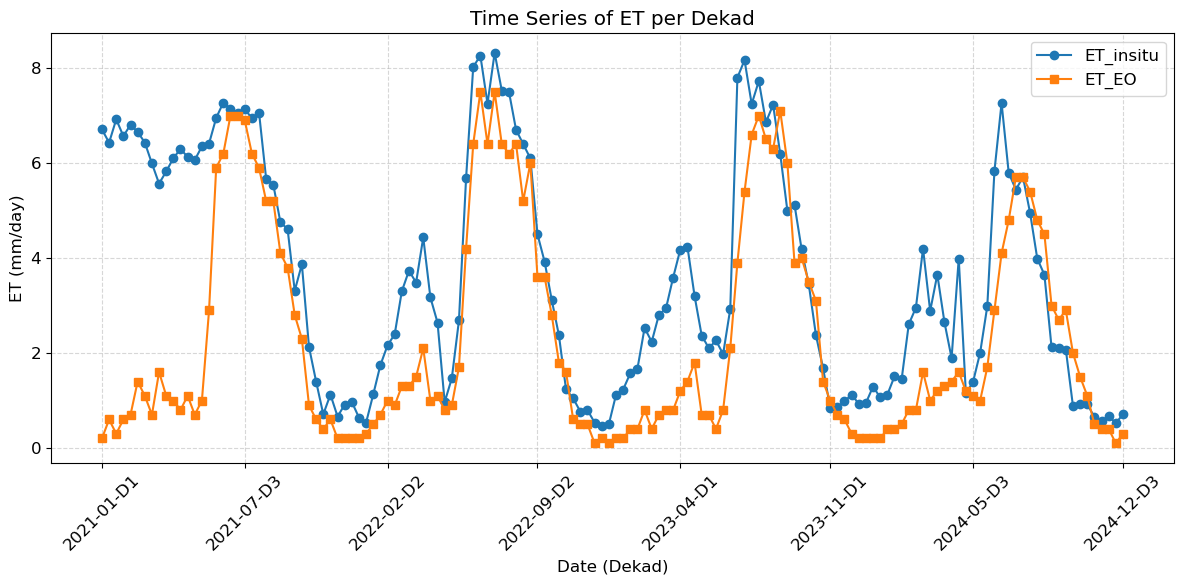

In [10]:
df = df_output
df["date"] = pd.Categorical(df["date"], categories=df["date"], ordered=True)

# Plot
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["ET_insitu (mm/day)"], marker='o', label="ET_insitu")
plt.plot(df["date"], df["ET_EO (mm/day)"], marker='s', label="ET_EO")

n_labels = 8
positions = np.linspace(0, len(df)-1, n_labels, dtype=int)
labels = df["date"].iloc[positions]
plt.xticks(positions, labels) 

plt.xlabel("Date (Dekad)")
plt.ylabel("ET (mm/day)")
plt.title("Time Series of ET per Dekad")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

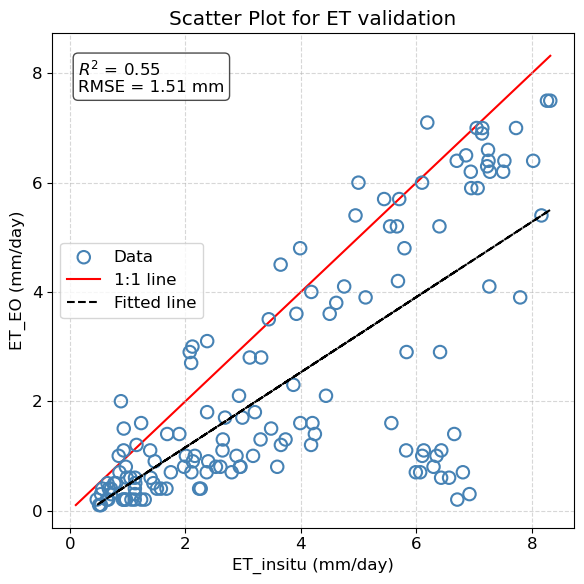

In [21]:
X = df["ET_insitu (mm/day)"].values.reshape(-1, 1)
y = df["ET_EO (mm/day)"].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Compute metrics
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(X, y, facecolors='none', linewidths=1.5, edgecolors='steelblue', s=80, label='Data', zorder=2)

# 1:1 line (solid red)
min_val = min(X.min(), y.min())
max_val = max(X.max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r-', label='1:1 line', zorder=1)

# Fitted regression line (dashed black)
plt.plot(X, y_pred, 'k--', label='Fitted line', zorder=2)

# Labels, title
plt.xlabel("ET_insitu (mm/day)")
plt.ylabel("ET_EO (mm/day)")
plt.title("Scatter Plot for ET validation")
# Show R² and RMSE inside figure
plt.text(0.05, 0.95, f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f} mm", transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()